In [ ]:
# default_exp basic_agents
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# export
import torch, torch.nn.functional as F
from torch import ByteTensor, DoubleTensor, FloatTensor, HalfTensor, LongTensor, ShortTensor, Tensor
from torch import nn, optim, as_tensor
from torch.utils.data import BatchSampler, DataLoader, Dataset, Sampler, TensorDataset
from torch.nn.utils import weight_norm, spectral_norm
from dataclasses import asdict,dataclass
from typing import Callable,Tuple,Union
import textwrap
import numpy as np
import logging

"Note these are modified versions of 'Shmuma/Ptan'. Github, 2020, https://github.com/Shmuma/ptan/blob/master/ptan/agent.py. Accessed 13 June 2020."

"Note these are modified versions of 'Shmuma/Ptan'. Github, 2020, https://github.com/Shmuma/ptan/blob/master/ptan/agent.py. Accessed 13 June 2020."

In [ ]:
# hide
from nbdev.showdoc import *
from nbdev.imports import *
from nbdev.export2html import *
from fastcore.foundation import *
if not os.environ.get("IN_TEST", None):
    assert IN_NOTEBOOK
    assert not IN_COLAB
    assert IN_IPYTHON

In [ ]:
# hide
logging.basicConfig(format='[%(asctime)s] p%(process)s line:%(lineno)d %(levelname)s - %(message)s',
                    datefmt='%m-%d %H:%M:%S')
_logger=logging.getLogger(__name__)
_logger.setLevel('INFO')

from fastai.torch_core import *
from fastai.basic_data import *
from fastai.basic_train import *
import pytest
import gym

# Basic Action Selection

> Methods of exploratively selecting actions based on a model state input.

In [ ]:
# export
class ActionSelector:
    "Abstract class which converts scores to the actions."
    def __call__(self,scores):raise NotImplementedError

class ArgmaxActionSelector(ActionSelector):
    "Selects actions using argmax."
    def __call__(self,scores):
        assert isinstance(scores,np.ndarray)
        return np.argmax(scores,axis=1)

@dataclass
class EpsilonGreedyActionSelector(ActionSelector):
    epsilon:float=0.05
    selector:ActionSelector=ArgmaxActionSelector()

    def __call__(self,scores):
        assert isinstance(scores,np.ndarray)
        bs,n_a=scores.shape
        a=self.selector(scores)
        mask=np.random.random(size=bs)<self.epsilon
        rand_a=np.random.choice(n_a, sum(mask))
        a[mask]=rand_a
        return a

class ProbabilityActionSelector(ActionSelector):
    "Converts probabilities of actions into action by sampling them."
    def __call__(self,probs):
        assert isinstance(probs,np.ndarray)
        actions=[np.random.choice(len(prob),p=prob) for prob in probs]
        return np.array(actions)

# Basic Agents

> Basic Agent classes for handling models and actions. Details, please ref `basic_train`

There is an important difference between `Learner`'s, `nn.Module`'s, and `Agent`'s. 

`Learners`:
- Ref `basic_train`

`nn.Module`:
- Contain only `pytorch` related code.
- Function as the brain of any of these agents and are the objects to be optimized.
- Are highly portable, however for runtime usage are too "dumb" or simple to be practical. If by themselves, extra code needs to wrap them to handle environments.

`Agent` (`agent_core`):
- Contain a `nn.Module` and a limited number of `fastrl` objects. Unlike `nn.Module`, these can maintain a state.
- Function as the interface between the `nn.Module` and the environments. They have 2 goals:
    - Convert states into something the `nn.Module` can interpret.
    - Modify the `nn.Module` output (actions) for randomized exploration.
- Designed to be highly portable only requiring `basic_agents` as a dependency. These should allow for easily saving, and using in environments where `fastrl` might not necessarily be installed.

In [ ]:
# export
def default_states_preprocessor(s,dtype=np.float32):
    "Convert list of states into the form suitable for model. By default we assume Variable."
    np_s=np.expand_dims(s,0) if len(np.array(s).shape)==1 else np.array(s, copy=False)
    return torch.tensor(np_s.astype(dtype))

def float32_preprocessor(s):
    np_s=np.array(s, dtype=np.float32)
    return torch.tensor(np_s)

In [ ]:
# export
@dataclass
class BaseAgent(object):
    model:nn.Module=None # If None, learner will set
    def initial_state(self):return None
    def __call__(self,sl,asl,include_batch_dim=False):
        assert isinstance(sl,(list,np.ndarray))
        assert isinstance(asl,(list,np.ndarray))
        assert len(asl)==len(sl)
        raise NotImplementedError()
        
        
@dataclass
class TestAgent(BaseAgent):
    env:object=None
    def initial_state(self):return None
    def __call__(self,sl,asl=None,include_batch_dim=False):
        if type(self.env)!=list:return self.env.action_space.sample(),None
        return self.env[0].action_space.sample(),None

In [ ]:
add_docs(BaseAgent.initial_state,"Should create initial empty state for the agent. It will be called for the start of the episode.")
add_docs(BaseAgent.__call__,textwrap.fill("""Convert observations and state list `sl` into actions to take. Agent state list `asl` may also be used by the agent.
         It is expected that `asl` is likely either going to be an internal state tracked by the agent, or it is simply a parameter used during subclassing.
         The `include_batch_dim` should toggle whether to remove/include the batch dim of an action. Naturally, `gym` envs don't understand batch dimensions."""
        ))
add_docs(BaseAgent,"Abstract Agent interface")

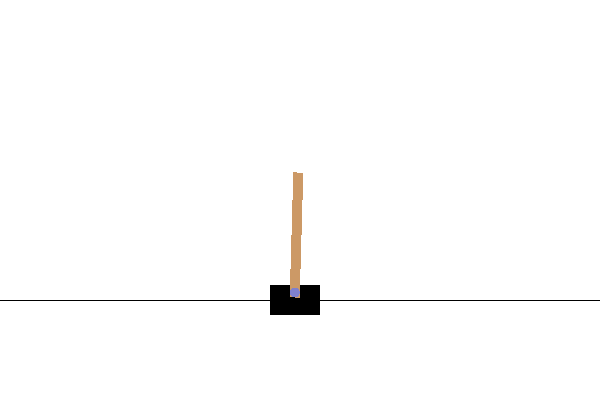

In [ ]:
if IN_NOTEBOOK:
    from IPython import display
    import PIL.Image

env=gym.make('CartPole-v1')
agent=TestAgent(env=env)

done,episode_count,max_episodes=True,0,10

while True:
    if done:s=env.reset()
    s,done,r,_=env.step(agent(s)[0])
    display.clear_output(wait=True)
    im=env.render(mode='rgb_array')
    new_im=PIL.Image.fromarray(im)
    display.display(new_im)
    if done and episode_count>max_episodes:break
    if done:episode_count+=1

In [ ]:
# export
@dataclass
class DiscreteAgent(BaseAgent):
    "DQNAgent is a memoryless DQN agent which calculates Q values from the observations and  converts them into the actions using a_selector."
    a_selector:ActionSelector=None
    device:str=None
    preprocessor:Callable=default_states_preprocessor
    apply_softmax:bool=False
        
    def safe_unbatch(self,o:np.array)->np.array:return o[0] if o.shape[0]==1 and len(o.shape)>1 else o
    def split_v(v,asl): return v,asl

    @torch.no_grad()
    def __call__(self,s,asl=None,include_batch_dim=False)->Tuple[np.array,np.array]:
        s=self.preprocessor(s) if self.preprocessor is not None else s
        asl= np.zeros(s.shape) if asl is None else asl
        s=s.to(self.device) if torch.is_tensor(s) else s
        v=self.model(s)
        if type(v)==tuple:v,asl=self.split(v,asl)
        if self.apply_softmax:
            v=F.softmax(v,dim=1)
        q=v.data.cpu().numpy()
        al=self.a_selector(q)
        if not include_batch_dim:al=self.safe_unbatch(al).tolist()
        return al if len(al)!=1 or include_batch_dim else al[0],asl

@dataclass
class DQNAgent(DiscreteAgent):
    "DQNAgent is a memoryless DQN agent which calculates Q values from the observations and  converts them into the actions using a_selector."
    def __post_init__(self):
        self.a_selector=ifnone(self.a_selector,ArgmaxActionSelector())

In [ ]:
add_docs(DQNAgent,__call__='DQNAgents will likely never have `asl` passed and used. This is however here for novel DQN implimentations.',
         safe_unbatch='Will remove the batch dim from `o` if `o` represents a single item.',
         split_v='In the event that `v` is a tuple, then there is multle ouputs from the `model`. Primarly used for A2C.')

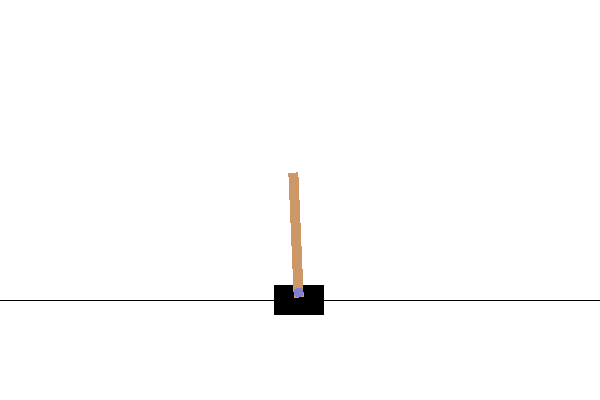

In [ ]:
env=gym.make('CartPole-v1')
agent=DQNAgent(model=nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2)))

done,episode_count,max_episodes=True,0,10

while True:
    if done:s=env.reset()
    s,done,r,_=env.step(agent(s)[0])
    display.clear_output(wait=True)
    im=env.render(mode='rgb_array')
    new_im=PIL.Image.fromarray(im)
    display.display(new_im)
    if done and episode_count>max_episodes:break
    if done:episode_count+=1

In [ ]:
class TargetNet:
    "Wrapper around model which provides copy of it instead of trained weights."
    def __init__(self, model):
        self.model = model
        self.target_model = copy.deepcopy(model)

    def sync(self):self.target_model.load_state_dict(self.model.state_dict())
    def alpha_sync(self,alpha):
        "Blend params of target net with params from the model."
        assert isinstance(alpha,float)
        assert 0.0<alpha<=1.0
        state=self.model.state_dict()
        tgt_state=self.target_model.state_dict()
        for k, v in state.items():
            tgt_state[k]=tgt_state[k]*alpha+(1-alpha)*v
        self.target_model.load_state_dict(tgt_state)

@dataclass
class PolicyAgent(DiscreteAgent):
    "Policy agent gets action probabilities from the model and samples actions from it."
    def __post_init__(self):
        self.a_selector=ifnone(self.a_selector,actions.ProbabilityActionSelector())
        self.apply_softmax=True

class ActorCriticAgent(PolicyAgent):
    "Policy agent which returns policy and value tensors from observations. Value are stored in agent's state \
     and could be reused for rollouts calculations by ExperienceSource."
    def split_v(v,asl):return v,v.data.squeeze().cpu().numpy()

In [ ]:
# hide
from nbdev.export import *
notebook2script()
notebook2html(n_workers=0)

Converted 00_core.ipynb.
Converted 01_wrappers.ipynb.
Converted 02_callbacks.ipynb.
Converted 03_basic_agents.ipynb.
Converted 05_data_block.ipynb.
Converted 06_basic_train.ipynb.
Converted index.ipynb.
Converted notes.ipynb.
converting: /opt/project/fastrl/nbs/03_basic_agents.ipynb
converting: /opt/project/fastrl/nbs/05_data_block.ipynb
